# Do some imports

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.nn.init as init
import skimage.filters as filters

Let us use a spectral line that is purely Gaussian and parameterized by the depth and the velocity shift. The width of the line is assumed to be fixed and known for this simple model.

In [2]:
nl = 100
wavel = np.linspace(-1, 1, nl)
depth = 0.4
sigma = 0.2
v = 0.0
y = 1.0 - depth * np.exp(-(wavel-v)**2 / sigma**2)

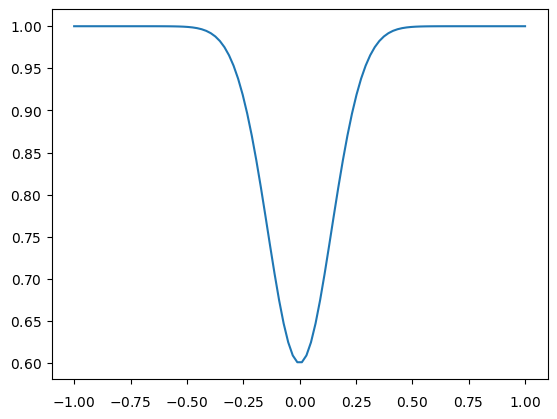

In [3]:
fig, ax = pl.subplots()
ax.plot(wavel, y)

As a first step, let us consider that the depth is known and we want to infer the per-pixel velocity shift. We generate a shift by getting an array of 50x50 and convolving it with a Gaussian window of 1 pixel width. This introduces spatial correlation and it looks similar to what one sees in the Sun.

Text(0.5, 1.0, 'Spatially filtered random noise')

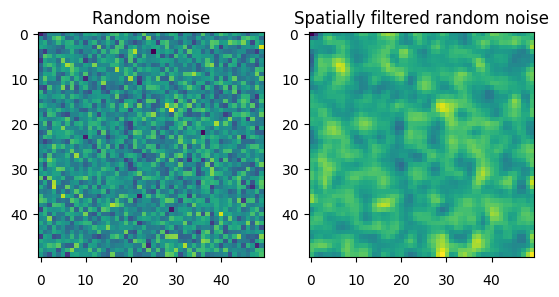

In [4]:
nx = 50
ny = 50
tmp = np.random.normal(loc=0, scale=0.75, size=(nx, ny))
v = filters.gaussian(tmp, sigma=1)
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(tmp)
ax[1].imshow(v)
ax[0].set_title('Random noise')
ax[1].set_title('Spatially filtered random noise')

We use this model for the velocity shift to compute the emergent spectral line at each pixel. Note that we take advantage of numpy broadcasting for doing this calculation without loops.

In [5]:
stokes = 1.0 - depth * np.exp(-(wavel[None,None,:]-v[:,:,None])**2 / sigma**2)
stokes_noise = stokes + np.random.normal(loc=0, scale=1e-3, size=stokes.shape)

In [6]:
stokes.shape

(50, 50, 100)

Let's see a few profiles. Note that we have added noise.

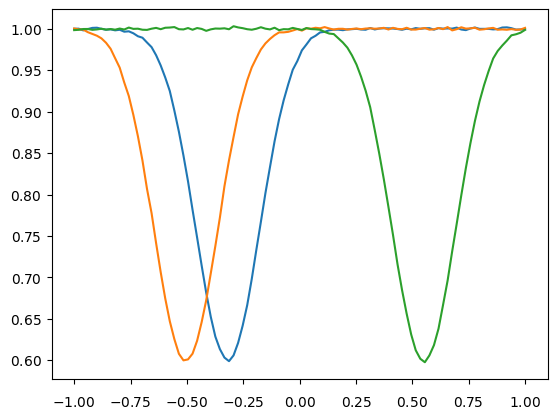

In [7]:
fig, ax = pl.subplots()
ax.plot(wavel, stokes_noise[10, 10, :])
ax.plot(wavel, stokes_noise[20, 20, :])
ax.plot(wavel, stokes_noise[40, 40, :])

We want to use "neural fields" to recover the information by taking into account the spatial structure of the observations. To this end, let us first define a grid of points [-1,1]x[-1,1] that span the image in normalized units.

In [8]:
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
X = X.reshape((nx*ny))
Y = Y.reshape((nx*ny))

Do we have a GPU to accelerate calculations?

In [9]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


Now we define the neural fields. The first thing we define is a random Fourier encoding (https://bmild.github.io/fourfeat/), that we show later it strongly improves the capabilities of the model. Then the neural field is just a mapping from (x,y) to velocity(x,y). To this end, we use a simple neural network that takes (x,y) as input and produces a scalar as output.

In [10]:
class PositionalEncoding(nn.Module):
    """Positional encoding for the input vector

    gamma(v) = [..., cos(2 * pi * sigma ** (j / m) * v), sin(2 * pi * sigma ** (j / m) * v), ...]

    Parameters
    ----------
    nn : _type_
        _description_
    """
    def __init__(self, sigma, n_freqs, input_size):
        super().__init__()
        self.sigma = sigma
        self.n_freqs = n_freqs
        self.encoding_size = (2 * n_freqs + 1) * input_size

    def forward(self, v, alpha=None):

        n_batch, n_input = v.shape

        if (alpha is None):
            alpha = 1.0
        
        k = torch.arange(self.n_freqs, device=v.device)

        weight = 0.5 * (1.0 - torch.cos((alpha * self.n_freqs - k) * np.pi))
        weight[alpha * self.n_freqs < k] = 0.0
        weight[alpha * self.n_freqs - k >= 1] = 1.0        
        weight = weight[None, None, :]

        coeffs = 2 * np.pi * self.sigma ** (1.0 * k / self.n_freqs)
        vp = coeffs * torch.unsqueeze(v, -1)
        vp_cat = torch.cat((weight * torch.cos(vp), weight * torch.sin(vp)), dim=-1)

        out = vp_cat.flatten(-2, -1)

        out = torch.cat((v, out), dim=-1)

        return out
        
    
class GaussianEncoding(nn.Module):
    def __init__(self, input_size, encoding_size, sigma=None):
        super().__init__()
        self.sigma = sigma
        self.input_size = input_size
        self.encoding_size_half = encoding_size
        self.encoding_size = 2 * encoding_size + input_size

        # Fourier matrix        
        B = self.sigma * torch.randn((encoding_size, self.input_size))
        self.B_max = torch.max(torch.abs(B))

        # Compute the frequency to reorder the Fourier matrix
        freq = torch.sqrt(torch.sum(B**2, dim=1))
        _, idx = torch.sort(freq, descending=False)
        B = B[idx, :]
        
        self.register_buffer("B", B)

    def forward(self, v, alpha=None):                
        if (alpha is None):
            alpha = 1.0

        k = torch.arange(self.encoding_size_half, device=v.device)
            
        weight = 0.5 * (1.0 - torch.cos((alpha * self.encoding_size_half - k) * np.pi))
        weight[alpha * self.encoding_size_half < k] = 0.0
        weight[alpha * self.encoding_size_half - k >= 1] = 1.0
        
        vp = 2.0 * np.pi * v @ self.B.T

        out = torch.cat([weight * torch.cos(vp), weight * torch.sin(vp)], dim=-1)
    
        out = torch.cat((v, out), dim=-1)

        return out

class IdentityEncoding(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoding_size = input_size
        
    def forward(self, v, alpha=None):

        return v

In [54]:
def init_kaiming(m):
    if type(m) == nn.Linear:
        init.kaiming_uniform_(m.weight, nonlinearity='relu')

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module
        
class MLP(nn.Module):
    def __init__(self, n_input, n_output, dim_hidden=1, n_hidden=1, activation=nn.ReLU(), bias=True, final_activation=nn.Identity(), zero_init=False):
        """Simple fully connected network, potentially including FiLM conditioning

        Parameters
        ----------
        n_input : int
            Number of input neurons
        n_output : int
            Number of output neurons
        n_hidden : int, optional
            number of neurons per hidden layers, by default 1
        n_hidden_layers : int, optional
            Number of hidden layers, by default 1        
        activation : _type_, optional
            Activation function to be used at each layer, by default nn.Tanh()
        bias : bool, optional
            Include bias or not, by default True
        final_activation : _type_, optional
            Final activation function at the last layer, by default nn.Identity()
        """
        super().__init__()


        self.activation = activation
        self.final_activation = final_activation

        self.layers = nn.ModuleList([])        
        
        self.layers.append(nn.Linear(n_input, dim_hidden, bias=bias))
        
        for i in range(n_hidden):
            self.layers.append(nn.Linear(dim_hidden, dim_hidden, bias=bias))            

        if (zero_init):
            self.last_layer = zero_module(nn.Linear(dim_hidden, n_output))
        else:
            self.last_layer = nn.Linear(dim_hidden, n_output)
            self.last_layer.apply(init_kaiming)

        self.layers.apply(init_kaiming)        
        
    def forward(self, x, gamma=None, beta=None):

        # Apply all layers
        for layer in self.layers:

            # Apply conditioning if present
            if (gamma is not None):
                x = layer(x) * gamma
            else:
                x = layer(x)

            if (beta is not None):
                x += beta

            x = self.activation(x)
        
        x = self.last_layer(x)
        x = self.final_activation(x)
        
        return x

Let us see the effect of the Fourier encoding. We instantiate two neural networks, one using (x,y) as inputs and the other one using a Fourier encoding before entering into the network.

In [58]:
model = MLP(n_input=2, n_output=1, dim_hidden=64, n_hidden=5, zero_init=False).to(device)
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model_encoding = MLP(n_input=encoding.encoding_size, n_output=1, dim_hidden=64, n_hidden=5).to(device)

In [59]:
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
XY = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    out = model(XY).squeeze().reshape((nx, ny)).cpu().numpy()
    XY_encoded = encoding(XY)
    out_encoding = model_encoding(XY_encoded).squeeze().reshape((nx, ny)).cpu().numpy()

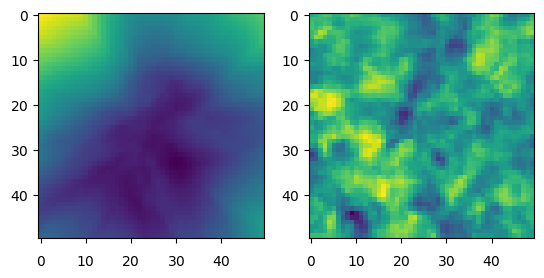

In [60]:
fig, ax = pl.subplots(ncols=2)
ax[0].imshow(out)
ax[1].imshow(out_encoding)

We see that the frequencies that we end up having with the Fourier encoding are much higher.

We define the neural network (2 inputs, 1 output, 5 hidden layers with 64 neurons each). We transform x and y to PyTorch tensors and instantiate the optimizer.

In [61]:
model = MLP(n_input=2, n_output=1, dim_hidden=64, n_hidden=5, zero_init=True).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny, nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Now we do the training loop, that includes an (optional) annealer for the learning rate. At each iteration, we evaluate the Gaussian spectral line at each position in the batch and compare with the observations.

In [62]:
n_epochs = 50
batch_size = 50

# Divide the image in batches of equal size and randomly sampled in the (x,y) plane
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size    
    for batch in range(n_batches):

        optimizer.zero_grad()
        
        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]
        velocity = model(xy).squeeze()
        stokes_syn = 1.0 - depth * torch.exp(-(wavel_th[None,:]-velocity[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        scheduler.step()
        
        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()}')

Epoch :0 - L=0.009722104296088219
Epoch :1 - L=0.009588942863047123
Epoch :2 - L=0.00882669072598219
Epoch :3 - L=0.008421766571700573
Epoch :4 - L=0.008469115942716599
Epoch :5 - L=0.008578226901590824
Epoch :6 - L=0.007947325706481934
Epoch :7 - L=0.008321930654346943
Epoch :8 - L=0.0077495453879237175
Epoch :9 - L=0.007487486116588116
Epoch :10 - L=0.008142133243381977
Epoch :11 - L=0.007230029441416264
Epoch :12 - L=0.007480251137167215
Epoch :13 - L=0.007162359543144703
Epoch :14 - L=0.006740988697856665
Epoch :15 - L=0.007045484147965908
Epoch :16 - L=0.006855596322566271
Epoch :17 - L=0.006074521224945784
Epoch :18 - L=0.006174905225634575
Epoch :19 - L=0.00633661774918437
Epoch :20 - L=0.005953260697424412
Epoch :21 - L=0.00660661468282342
Epoch :22 - L=0.006147373002022505
Epoch :23 - L=0.006486963015049696
Epoch :24 - L=0.0055412291549146175
Epoch :25 - L=0.005991232581436634
Epoch :26 - L=0.005449182353913784
Epoch :27 - L=0.005126139149069786
Epoch :28 - L=0.006073644384741

You can see that convergence is slow. Let's evaluate the model on the 50x50 array of (x,y) coordinates and see the result.

In [63]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    velocity_final = model(xy).squeeze().reshape((nx, ny)).cpu().numpy()

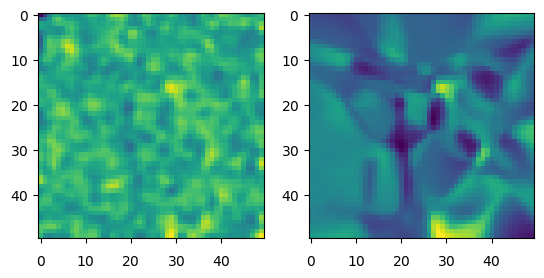

In [64]:
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(v)
ax[1].imshow(velocity_final)

We see some hints of convergence, but results are not good. The reason for this is the "low-frequency bias" that neural networks have. They are good at representing structures with low spatial frequency, but not if they contain high frequencies. We can do some search over architectures/learning rate/activation functions to see if this improves. Anyway, let's use Fourier mapping as a first layer to see that things improve a lot. This gives a large flexibility to the network to produce high-frequency structures.

## Fourier encoding

In [65]:
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model = MLP(n_input=encoding.encoding_size, n_output=1, dim_hidden=64, n_hidden=5, zero_init=True).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny, nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
tanh = nn.Tanh()

In [66]:
n_epochs = 50
batch_size = 50
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

model.train()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size    
    for batch in range(n_batches):

        optimizer.zero_grad()
        
        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]
        xy_encoded = encoding(xy)
        velocity = 0.5 * tanh(model(xy_encoded).squeeze())
        stokes_syn = 1.0 - depth * torch.exp(-(wavel_th[None,:]-velocity[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        #scheduler.step()
        
        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()}')

Epoch :0 - L=0.008162382058799267
Epoch :1 - L=0.006461611017584801
Epoch :2 - L=0.004998100455850363
Epoch :3 - L=0.0038735554553568363
Epoch :4 - L=0.0038197773974388838
Epoch :5 - L=0.004295967053622007
Epoch :6 - L=0.003695568535476923
Epoch :7 - L=0.003327163401991129
Epoch :8 - L=0.0027519569266587496
Epoch :9 - L=0.0026115302462130785
Epoch :10 - L=0.0028865968342870474
Epoch :11 - L=0.003254199866205454
Epoch :12 - L=0.003087411168962717
Epoch :13 - L=0.002657900331541896
Epoch :14 - L=0.002512803301215172
Epoch :15 - L=0.0034776527900248766
Epoch :16 - L=0.001465784851461649
Epoch :17 - L=0.0017123233992606401
Epoch :18 - L=0.0015613991999998689
Epoch :19 - L=0.0010444323997944593
Epoch :20 - L=0.0012093331897631288
Epoch :21 - L=0.0016933780862018466
Epoch :22 - L=0.0013310792855918407
Epoch :23 - L=0.00158337177708745
Epoch :24 - L=0.0012211874127388
Epoch :25 - L=0.0017503871349617839
Epoch :26 - L=0.0017446954734623432
Epoch :27 - L=0.0016043990617617965
Epoch :28 - L=0.00

In [67]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    xy_encoded = encoding(xy)
    velocity_final = model(xy_encoded).squeeze().reshape((nx, ny)).cpu().numpy()

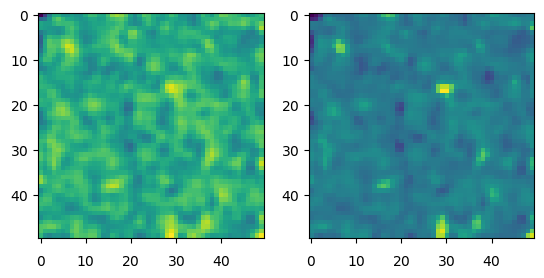

In [68]:
fig, ax = pl.subplots(nrows=1, ncols=2)
ax[0].imshow(v)
ax[1].imshow(velocity_final)

We see that the results are much better now, with a much faster convergence.

# Infer two quantities
Now, let's add the depth of the line as a new variable and try to recover both from observations. We assume that depth changes with a much larger spatial frequency.

Text(0.5, 1.0, 'Spatially filtered random noise')

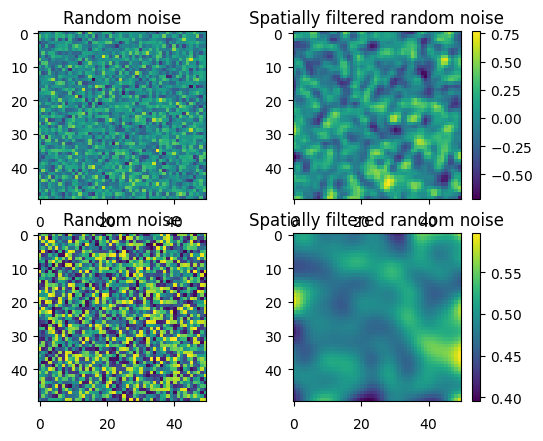

In [69]:
nx = 50
ny = 50
tmp1 = np.random.normal(loc=0, scale=0.75, size=(nx, ny))
v = filters.gaussian(tmp1, sigma=1)

tmp2 = np.random.uniform(low=0.1, high=0.9, size=(nx, ny))
depth = filters.gaussian(tmp2, sigma=3)

fig, ax = pl.subplots(nrows=2, ncols=2)
ax[0,0].imshow(tmp1)
im = ax[0,1].imshow(v)
ax[0,0].set_title('Random noise')
ax[0,1].set_title('Spatially filtered random noise')
pl.colorbar(im, ax=ax[0,1])
ax[1,0].imshow(tmp2)
im = ax[1,1].imshow(depth)
pl.colorbar(im, ax=ax[1,1])
ax[1,0].set_title('Random noise')
ax[1,1].set_title('Spatially filtered random noise')

We compute the synthetic observations and add noise.

In [70]:
stokes = 1.0 - depth[:,:,None] * np.exp(-(wavel[None,None,:]-v[:,:,None])**2 / sigma**2)
stokes_noise = stokes + np.random.normal(loc=0, scale=1e-3, size=stokes.shape)

We use a trick to activate low spatial frequencies first and then monotonically add the high frequencies. This usually gives good results, but you can see what happens if you remove it.

In [71]:
alpha_initial_iteration = 0
alpha_final_iteration = 1500

def alpha_schedule(iter):
    if (iter < alpha_initial_iteration):
        y = 0.0
    elif (iter > alpha_final_iteration):
        y = 1.0
    else:
        x0 = alpha_initial_iteration
        x1 = alpha_final_iteration
        y0 = 0.0
        y1 = 1.0
        y = np.clip((y1 - y0) / (x1 - x0) * (iter - x0) + y0, y0, y1)
    
    return torch.tensor(float(y)).to(device)

In [32]:
encoding = GaussianEncoding(input_size=2, sigma=1.0, encoding_size=64).to(device)
model = MLP(n_input=encoding.encoding_size, n_output=2, dim_hidden=64, n_hidden=5).to(device)
X_th = torch.tensor(X.astype('float32')).to(device)
Y_th = torch.tensor(Y.astype('float32')).to(device)
stokes_noise_th = torch.tensor(stokes_noise.reshape((nx*ny,nl)).astype('float32')).to(device)
wavel_th = torch.tensor(wavel.astype('float32')).to(device)

lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [36]:
n_epochs = 100
batch_size = 50
n_batches = nx*ny // batch_size
ind = np.arange(nx*ny)
np.random.shuffle(ind)
ind_th = torch.tensor(ind.astype('int')).to(device)

alpha = torch.tensor(0.0).to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=0.1*lr)

iter = 0

for epochs in range(n_epochs):
    left = 0
    right = left + batch_size    
    for batch in range(n_batches):

        optimizer.zero_grad()
        
        indices = ind_th[left:right]
        xx = X_th[indices]
        yy = Y_th[indices]
        xy = torch.cat([xx[:, None], yy[:, None]], dim=-1)
        stokes = stokes_noise_th[indices, :]

        # If you don't want to use the alpha annealing, just use alpha=1.0
        xy_encoded = encoding(xy, alpha=alpha)
        out = model(xy_encoded)
        velocity_th = out[:, 0]
        depth_th = out[:, 1]
        stokes_syn = 1.0 - depth_th[:, None] * torch.exp(-(wavel_th[None,:]-velocity_th[:,None])**2 / sigma**2)
        loss = torch.mean((stokes - stokes_syn)**2)

        loss.backward()
        optimizer.step()

        scheduler.step()

        # Update alpha in the range [0,1], all frequencies are active when alpha=1
        alpha = torch.clamp(alpha_schedule(iter), 0.0, 1.0)
        iter += 1
        
        left += batch_size
        right += batch_size
    print(f'Epoch :{epochs} - L={loss.item()} - iter={iter} - alpha={alpha}')

Epoch :0 - L=0.016144685447216034 - iter=50 - alpha=0.03266666829586029
Epoch :1 - L=0.01592174358665943 - iter=100 - alpha=0.06599999964237213
Epoch :2 - L=0.01585410162806511 - iter=150 - alpha=0.09933333098888397
Epoch :3 - L=0.016308220103383064 - iter=200 - alpha=0.1326666623353958
Epoch :4 - L=0.01471997331827879 - iter=250 - alpha=0.16599999368190765
Epoch :5 - L=0.013561541214585304 - iter=300 - alpha=0.1993333399295807
Epoch :6 - L=0.01429828628897667 - iter=350 - alpha=0.23266667127609253
Epoch :7 - L=0.014598052948713303 - iter=400 - alpha=0.26600000262260437
Epoch :8 - L=0.0138065991923213 - iter=450 - alpha=0.2993333339691162
Epoch :9 - L=0.012113415636122227 - iter=500 - alpha=0.33266666531562805
Epoch :10 - L=0.012537268921732903 - iter=550 - alpha=0.3659999966621399
Epoch :11 - L=0.012786912731826305 - iter=600 - alpha=0.39933332800865173
Epoch :12 - L=0.012111790478229523 - iter=650 - alpha=0.4326666593551636
Epoch :13 - L=0.010858770459890366 - iter=700 - alpha=0.4659

In [37]:
xy = torch.cat([X_th[:, None], Y_th[:, None]], dim=-1)
with torch.no_grad():
    xy_encoded = encoding(xy)
    out = model(xy_encoded).squeeze().reshape((nx, ny, 2)).cpu().numpy()

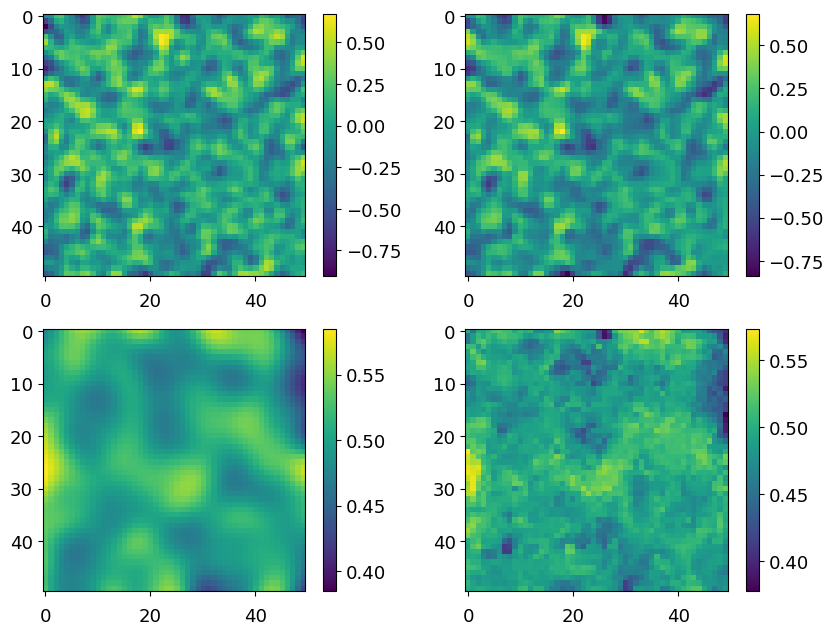

In [38]:
fig, ax = pl.subplots(nrows=2, ncols=2)
im = ax[0, 0].imshow(v)
pl.colorbar(im, ax=ax[0,0])
im = ax[0, 1].imshow(out[:, :, 0])
pl.colorbar(im, ax=ax[0,1])
im = ax[1, 0].imshow(depth)
pl.colorbar(im, ax=ax[1,0])
im = ax[1, 1].imshow(out[:, :, 1])
pl.colorbar(im, ax=ax[1,1])